In [1]:
# %%
from jp2tileaccesor.multi_res_Tiling import (
            SectionProxy, TileAccessor, Span, SectionMemmap, TileIterator
            )

import torch

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time
from  torch.cuda.amp import autocast


##########

psnr_score = []
def trt_version():
    return trt.__version__


def torch_version():
    return torch.__version__

def torch_dtype_to_trt(dtype):
    if trt_version() >= '7.0' and dtype == torch.bool:
        return trt.bool
    elif dtype == torch.int8:
        return trt.int8
    elif dtype == torch.int32:
        return trt.int32
    elif dtype == torch.float16:
        return trt.float16
    elif dtype == torch.float32:
        return trt.float32
    else:
        raise TypeError("%s is not supported by tensorrt" % dtype)


def torch_dtype_from_trt(dtype):
    if dtype == trt.int8:
        return torch.int8
    elif trt_version() >= '7.0' and dtype == trt.bool:
        return torch.bool
    elif dtype == trt.int32:
        return torch.int32
    elif dtype == trt.float16:
        return torch.float16
    elif dtype == trt.float32:
        return torch.float32
    else:
        raise TypeError("%s is not supported by torch" % dtype)


def torch_device_to_trt(device):
    if device.type == torch.device("cuda").type:
        return trt.TensorLocation.DEVICE
    elif device.type == torch.device("cpu").type:
        return trt.TensorLocation.HOST
    else:
        return TypeError("%s is not supported by tensorrt" % device)


def torch_device_from_trt(device):
    if device == trt.TensorLocation.DEVICE:
        return torch.device("cuda")
    elif device == trt.TensorLocation.HOST:
        return torch.device("cpu")
    else:
        return TypeError("%s is not supported by torch" % device)

import tensorrt as trt
TRT_LOGGER = trt.Logger(min_severity =trt.ILogger.INTERNAL_ERROR)



# %%

from collections import OrderedDict


class TileDataset(Dataset):
    def __init__(self,accessor):
        self.accessor = accessor
        
    def __len__(self):
        return len(self.accessor)
    
    def __getitem__(self,index):
        return torch.Tensor(self.accessor[index][0].copy())


import models.hovernet.net_desc as net
from run_utils.utils import convert_pytorch_checkpoint

def getmodel(model_path = 'hovernet_fast_pannuke_type_tf2pytorch.tar'):
    
    hovernet = net.HoVerNet(nr_types = 6,mode='fast')
    saved_state_dict = torch.load(model_path)["desc"]
    saved_state_dict = convert_pytorch_checkpoint(saved_state_dict)

    hovernet.load_state_dict(saved_state_dict, strict=True)
    
    return hovernet.eval()


def run_infer_load(dl,device):
    
    if device > 8:
        device = device%8
    dev = torch.device('cuda:'+str(device))
    
    torch.cuda.set_device(dev)
    
    start_load = time.perf_counter()
    
    mdl_gpu_half = getmodel().half().to(dev)
    mdl_gpu = getmodel().to(dev)
    
    start_i = time.perf_counter()
    
    _ = torch.set_grad_enabled(False)
    with autocast():
        for idx,batch in enumerate(dl):

            patch_imgs_gpu = batch.permute((0,3,1,2)).to(dev)
            fp32_patch = reformat(mdl_gpu(patch_imgs_gpu))
            patch_imgs_gpu_half = batch.permute((0,3,1,2)).half().to(dev)
            fp16_patch = reformat(mdl_gpu_half(patch_imgs_gpu_half))
            psnr_score.append(psnr(fp32_patch['np'].cpu().numpy(),fp16_patch['np'].cpu().numpy(),data_range = 1))
            if (psnr_score[-1] <95 and psnr_score[-1] >60 ):
                images['fp32'].append(fp32_patch)
                images['fp16'].append(fp16_patch)
                images['psnr'].append(psnr_score[-1])
                
            
    return device

from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
def reformat(out):
    pred_dict = {}
    pred_dict["tp"] = out[:,:6,:,:]
    pred_dict["np"] = out[:,6:8,:,:]
    pred_dict["hv"] = out[:,8:10,:,:]
    pred_dict = OrderedDict([[k, v.permute(0, 2, 3, 1).contiguous()] for k, v in pred_dict.items()])
    pred_dict["np"] = F.softmax(pred_dict["np"], dim=-1)[..., 1:]
    return pred_dict

def getdataset():
    proxy = SectionProxy()

    proxy.check_local_jp2()

    if not proxy.check_mmap():
        mmap = SectionMemmap(proxy)
        mmap.create()

    print(proxy.check_mmap())

# %%

    outsiz = 164,164
    insiz = 256,256
    hs = insiz[0]-outsiz[0]
    padsiz = hs//2
    accessor = TileAccessor(proxy,tilespan = Span(*outsiz),padding=padsiz, use_iip=False)

# %%

    ds = TileDataset(accessor)
    return ds


def main():
    
    ds = getdataset()
    print(len(ds))
    
    num_loaders = 8
    batch_siz = 128

    partsiz = len(ds)//num_loaders
    # print(partsiz)

    loaders = []
    for ii in range(num_loaders):
        # print(ii*partsiz,(ii+1)*partsiz)
        part = range(ii*partsiz,(ii+1)*partsiz)
        ds_sub = Subset(ds, part)

        loaders.append(DataLoader(ds_sub, batch_size = batch_siz, num_workers=12, drop_last=True))

    
    print('start')
    # concurrent
    start_time = time.perf_counter()
    if num_loaders > 1:
        with ThreadPoolExecutor(max_workers=num_loaders) as executor:
            for v,d in executor.map(run_infer_load,loaders,range(num_loaders)):
                pass
    else:
        run_infer_load(loaders[0],0)
        
    end_time = time.perf_counter()
    print(end_time-start_time)



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# import models.hovernet.net_desc as net
# from run_utils.utils import convert_pytorch_checkpoint
# model_path = 'hovernet_fast_pannuke_type_tf2pytorch.tar'
# hovernet = net.HoVerNet(nr_types = 6,mode='fast')
# saved_state_dict = torch.load(model_path)["desc"]
# saved_state_dict = convert_pytorch_checkpoint(saved_state_dict)

# hovernet.load_state_dict(saved_state_dict, strict=True)
# # hovernet = torch.nn.parallel.DataParallel(hovernet)
# hovernet = hovernet.to('cuda:0')
# hovernet.eval()

In [3]:
ds = getdataset()
print(len(ds))

num_loaders = 8
batch_siz = 32

partsiz = len(ds)//num_loaders

dl = DataLoader(ds, batch_size = batch_siz, num_workers=12, drop_last=True)

./storage/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2
True
253980


In [4]:
# run_infer_load(dl,0)

In [5]:
psnr_score = []
loaders = []
images = {'fp16' : [] , 'fp32' : [] , 'psnr' = []}
for ii in range(num_loaders):
    # print(ii*partsiz,(ii+1)*partsiz)
    part = range(ii*partsiz,(ii+1)*partsiz)
    ds_sub = Subset(ds, part)

    loaders.append(DataLoader(ds_sub, batch_size = batch_siz, num_workers=12, drop_last=True))


print('start')
# concurrent
start_time = time.perf_counter()
if num_loaders > 1:
    with ThreadPoolExecutor(max_workers=num_loaders) as executor:
        for v,d in executor.map(run_infer_load,loaders,range(num_loaders)):
            pass
else:
    run_infer_load(loaders[0],0)

end_time = time.perf_counter()
print(end_time-start_time)

start


TypeError: cannot unpack non-iterable int object

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

(array([2141., 1058., 1158.,  420.,  582.,  657.,  884.,  560.,  428.,
          48.]),
 array([ 68.16480581,  76.18028043,  84.19575505,  92.21122967,
        100.22670429, 108.24217891, 116.25765353, 124.27312815,
        132.28860277, 140.3040774 , 148.31955202]),
 <BarContainer object of 10 artists>)

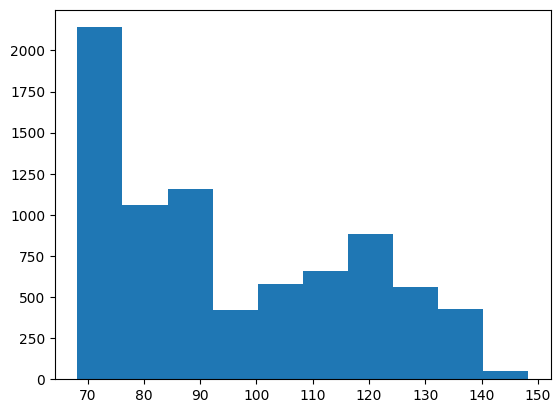

In [8]:
plt.hist(psnr_score)

In [10]:
len(psnr_score)*batch_siz

253952

In [18]:
print(len(ds))

253980


In [53]:
len(psnr_score)

7936

In [11]:
np_fp_16 = np.array(images['fp16'])
np_fp_32 = np.array(images['fp32'])

(array([2141., 1058., 1158.,  420.,  582.,  657.,  884.,  560.,  428.,
          48.]),
 array([ 68.16480581,  76.18028043,  84.19575505,  92.21122967,
        100.22670429, 108.24217891, 116.25765353, 124.27312815,
        132.28860277, 140.3040774 , 148.31955202]),
 <BarContainer object of 10 artists>)

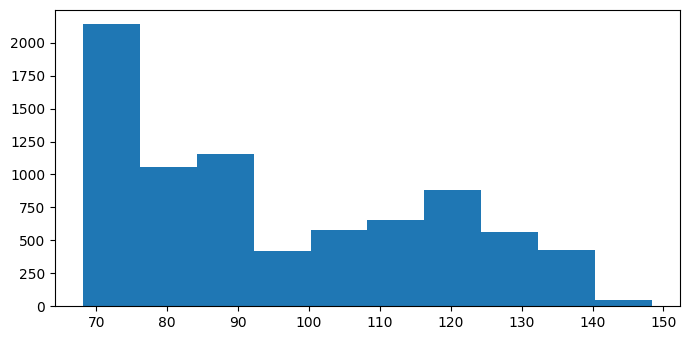

In [22]:
plt.hist(psnr_score_32)

In [62]:
import numpy as np
psnr_32 = np.array(psnr_score_32)

In [98]:
min(images['psnr'])

68.16480580823769

In [69]:
psnr_32.shape

(7936,)

In [67]:
len(images['fp32'])

4509

In [27]:
len(images['fp16'])

4509

In [99]:
threshold = 68.2
l_70 = images['psnr'][images['psnr']<threshold]
l_70_fp_16 = np_fp_16[images['psnr']<threshold]
l_70_fp_32 = np_fp_32[images['psnr']<threshold]

In [103]:
bct = 0
l_70[bct]

68.16480580823769

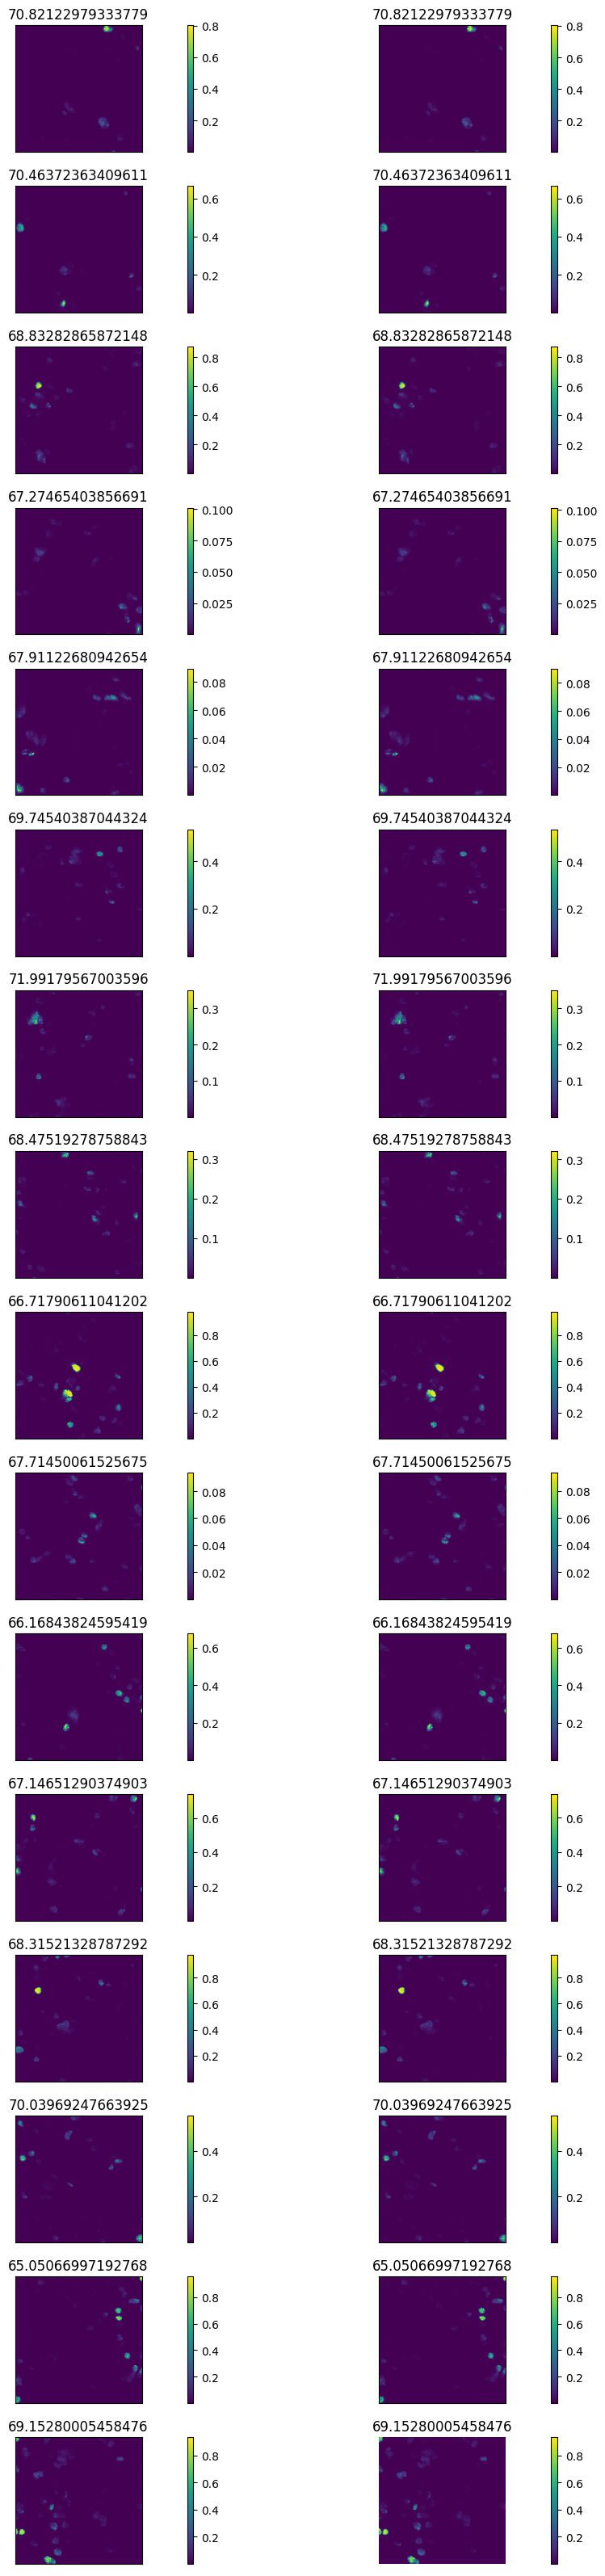

In [104]:
n=16
fig , axs = plt.subplots(n,2,figsize=(16,32))
plt.axis('off')
fr = {1 : 'fp16' , 0 : 'fp32'}
for i in range(0,n):
    for j in range(2):
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        t = axs[i,j].imshow(images[fr[j]][bct]['np'][i,:,:,:].cpu().numpy())
        plt.colorbar(t)
        axs[i,j].title.set_text(psnr(l_70_fp_32[bct]['np'][i,:,:,:].cpu().numpy(),l_70_fp_16[bct]['np'][i,:,:,:].cpu().numpy(),data_range = 1))

In [105]:
threshold = 70
l_70 = images['psnr'][images['psnr']<threshold]
l_70_fp_16 = np_fp_16[images['psnr']<threshold]
l_70_fp_32 = np_fp_32[images['psnr']<threshold]

In [106]:
len(l_70)

296

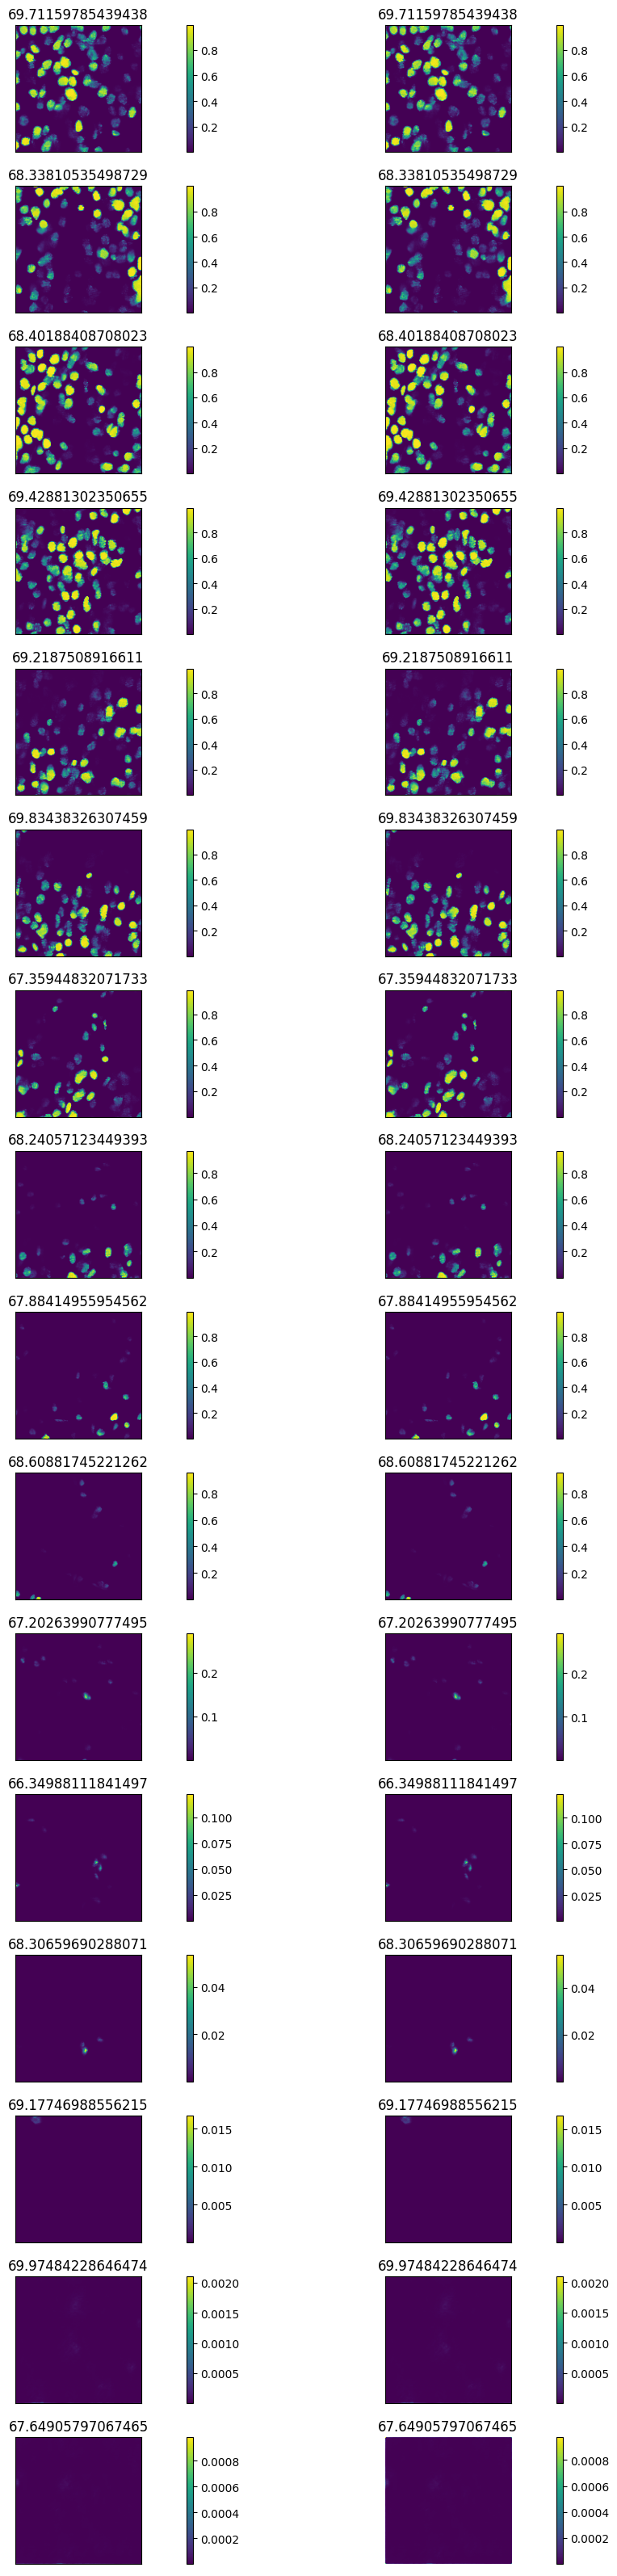

In [107]:
n=16
bct = 35
fig , axs = plt.subplots(n,2,figsize=(16,32))
plt.axis('off')
fr = {1 : 'fp16' , 0 : 'fp32'}
for i in range(0,n):
    for j in range(2):
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        t = axs[i,j].imshow(images[fr[j]][bct]['np'][i,:,:,:].cpu().numpy())
        plt.colorbar(t)
        axs[i,j].title.set_text(psnr(l_70_fp_32[bct]['np'][i,:,:,:].cpu().numpy(),l_70_fp_16[bct]['np'][i,:,:,:].cpu().numpy(),data_range = 1))

In [78]:
len(l_70)

296

In [73]:
# for i in range(len(images['fp16'])):
#     images['psnr'].append(psnr(images['fp32'][i]['np'].cpu().numpy(),images['fp16'][i]['np'].cpu().numpy(),data_range = 1))

In [44]:
bct=20

In [45]:
psnr(images['fp32'][bct]['np'].cpu().numpy(),images['fp16'][bct]['np'].cpu().numpy(),data_range = 1)

86.32176954166722

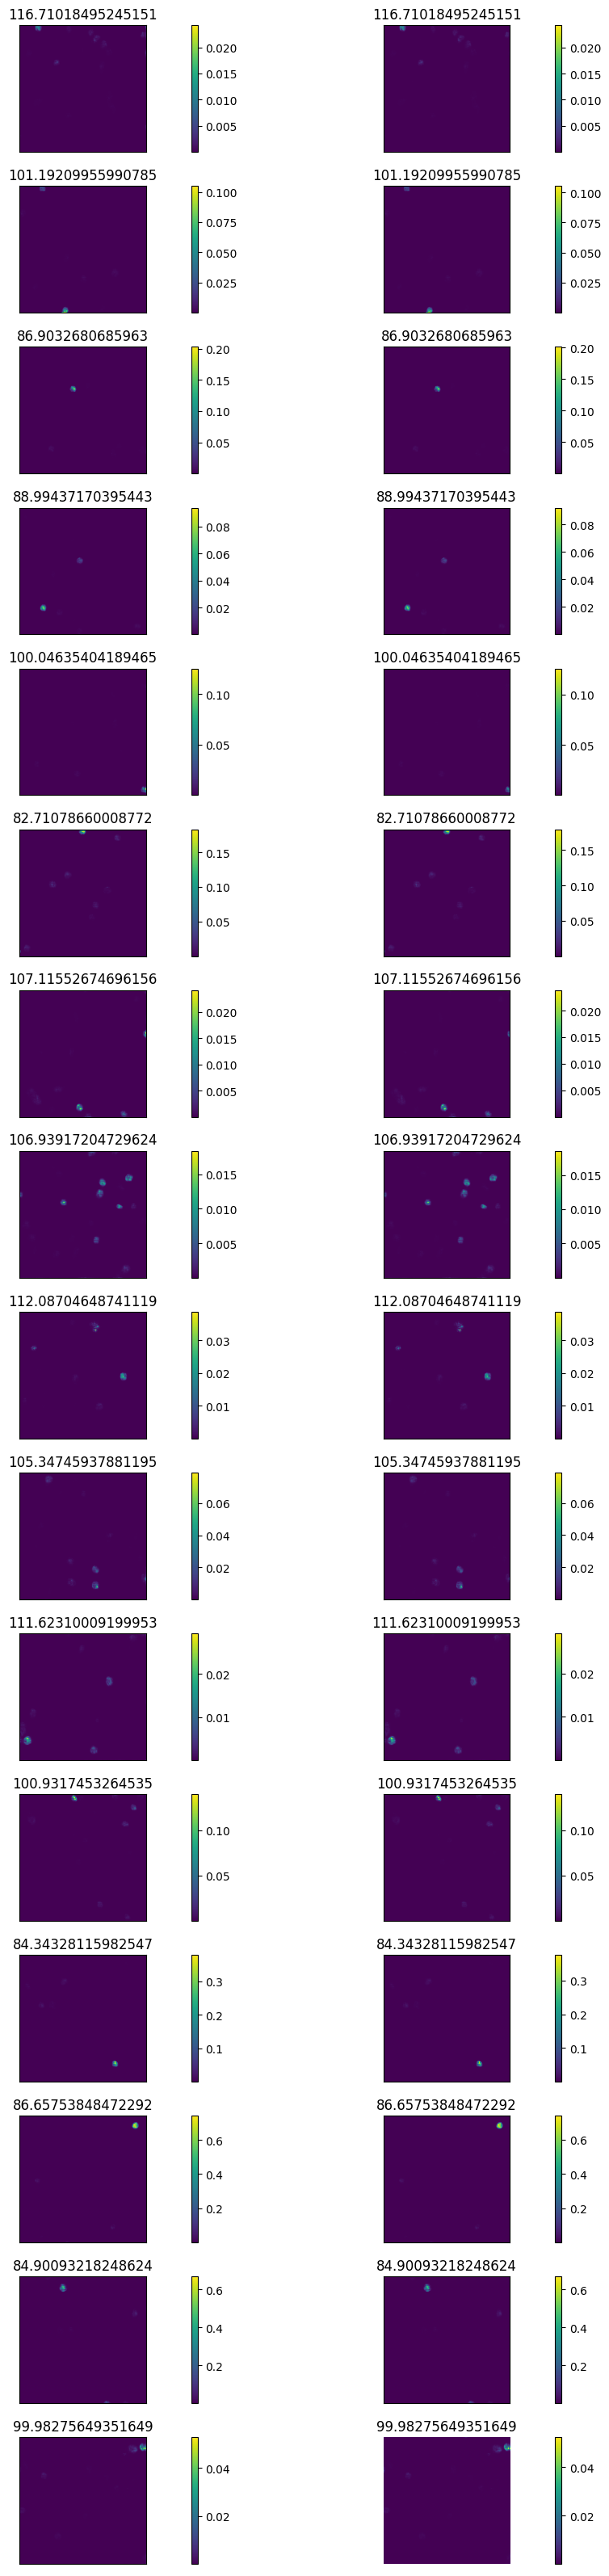

In [48]:
n=16
fig , axs = plt.subplots(n,2,figsize=(16,32))
plt.axis('off')
fr = {1 : 'fp16' , 0 : 'fp32'}
for i in range(0,n):
    for j in range(2):
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        t = axs[i,j].imshow(images[fr[j]][bct]['np'][i,:,:,:].cpu().numpy())
        plt.colorbar(t)
        axs[i,j].title.set_text(psnr(images['fp32'][bct]['np'][i,:,:,:].cpu().numpy(),images['fp16'][bct]['np'][i,:,:,:].cpu().numpy(),data_range = 1))